# Tutte Embedding



Graph theory sprawls across the mathematical landscape, connecting with set theory, logic, geometry, 
combinatorics, probability, algorithms etcetera.


This notebook uses the Python NetworkX library to explore Tutte embedding as described in a lecture 
by Daniel Spielman. The `NetworkX` library is abbreviated `nx` in code.


[Wikipedia article](https://en.wikipedia.org/wiki/Tutte_embedding)


Code attribution: 
[Github repo](https://github.com/jadenstock/Tutte-embedding/blob/master/TutteEmbedding.py) 
courtesy of Developer Jaden Stock. The code needed a couple minor updates to run properly.



A 3-vertex-connected planar graph can be supplied with springs for edges and allowed to 
relax into a minimal energy configuration where planarity is directly evident! The idea
here is to build a working implementation.

- Begin with G = a cycle of vertices
    - Add new edges at random while maintaining planarity
        - Reminds one of Kozyrev-Grindberg
    - Repeat until vertex connectivity reaches 3
    - Given N there is a maximum number of edges, empirically
        - N = 10: max edges = 24
        - N = 40: 114
        - N: 3N - 6
    - N = 200 is a bit of a wait
- We need vertices that comprise one face of G
    - Triangles are easy
    - Squares are a bit more effort
    - Pin the face vertices in the shape of a convex polygon
        - The face we begin with will be the *everything else* face in the end result
- Assign random positions to the remaining vertices; draw this
- Substitute springs for the he remaining edges: vertices can now move


```
while True:
    Calculate the potential energy of the system: Sum over springs
    Adjust positions of any vertex feeling a net force
        Strategy 1: move epsilon in the direction of net force
        Strategy 2: map G to a system of linear equations and solve
        Note the perimeter vertices are fixed
    Recalculate the potential energy, break if stable
draw the end result
```

In [54]:
import networkx as nx
from random import randint, random
from matplotlib import pyplot as plt
import numpy as np

In [55]:
def same_neighbors(G):
    '''pass a graph G, return a list of lists: vertices in the graph that share neighbors'''
    same_neighbors = []
    for u in G:
        same_neighbors_u = [u]
        for v in G:
            if v != u:
                if set(G[u]) == set(G[v]): same_neighbors_u.append(v)
        if len(same_neighbors_u) > 1: same_neighbors.append(same_neighbors_u)
    same_neighbors = [set(x) for x in same_neighbors]
    same = []
    for i in same_neighbors:
        if i not in same: same.append(i)
    same = [list(x) for x in same]
    return same

In [56]:
#input: a graph in the form of a dictionary and an outer_face in the form of a list of vertices.
def tutte_embedding(G, outer):
    '''From graph G with a list of outer face vertices outer: solve for and return coordinates for interior vertices'''
    
    print(G)
    pos = {} # dictionary of node positions
    tmp = nx.Graph()
    for edge in outer:
        a,b = edge
        tmp.add_edge(a,b)
    pos.update(nx.spectral_layout(tmp))
    outer = tmp.nodes()
    remaining_vertices = [x for x in G.nodes() if x not in outer]

    size = len(remaining_vertices)
    A = [[0 for i in range(size)] for i in range(size)] # system of eq'ns for (x, y) of remaining vertices
    b = [0 for i in range(size)]                        # elements of theses matrices indexed by remaining_vertices list
    C = [[0 for i in range(size)] for i in range(size)]
    d = [0 for i in range(size)]

    for u in remaining_vertices:
        i = remaining_vertices.index(u)
        neighbors = list(G.neighbors(u))
        n = len(neighbors)
        A[i][i] = 1
        C[i][i] = 1
        for v in neighbors:
            if v in outer:
                b[i] += float(pos[v][0])/n
                d[i] += float(pos[v][1])/n
            else:
                j = remaining_vertices.index(v)
                A[i][j] = -(1/float(n))
                C[i][j] = -(1/float(n))

    x, y = np.linalg.solve(A, b), np.linalg.solve(C, d)
    for u in remaining_vertices:
        i = remaining_vertices.index(u)
        pos[u] = [x[i],y[i]]
    return pos

In [57]:
# from source repo: One approach to configuring a simple test
# diamond1 = np.matrix([[0,1,1,1,0],[1,0,0,0,1],[1,0,0,0,1],[1,0,0,0,1],[0,1,1,1,0]])
# diamond3 = np.matrix([[0,1,1,1,0,0,1], [1,0,0,0,1,1,0], [1,0,0,0,1,1,1], [1,0,0,0,1,0,1], [0,1,1,1,0,1,1], [0,1,1,0,1,0,0], [1,0,1,1,1,0,0]])
# G = nx.from_numpy_array(diamond3)                         # G is a NetworkX Graph
# pos = tutte_embedding(G, [(0,1), (1,4), (4,3), (3,0)])    # these are outer face edges (not coordinates)
# nx.draw_networkx(G, pos)
# plt.show()

In [58]:
# Plot G in a Tutte-oriented way
def TuttePlot(G, pos, color, do_numbers=False):
    plt.figure(figsize=(7, 7))
    nx.draw_networkx_edges(G, pos)
    nx.draw_networkx_nodes(G, pos, node_size=10, node_color = color)
    if do_numbers:
        labels = nx.draw_networkx_labels(G, pos, font_size = 26)
    plt.axis('off')
    plt.show()

In [59]:
# These cells construct a planar G per the notes above.
#   G begins as a ring of vertices; edges added while preserving planarity

def GeneratePlanarGraph(N):
    # The starting ring
    G, pos = nx.Graph(), [[]]*N
    for i in range(N-1): G.add_edge(i, i+1)
    G.add_edge(0, N-1)
    print("G nodes = ", G.number_of_nodes(), "now arranged in a ring.")

    # Add edges on a trial and error basis
    done = False
    tries = 0
    try_limit = 10000
    c_max = 0
    add_try_max = 0
    while not done:
        tries += 1
        H = G.copy()
        i = randint(0, N-1)
        j = randint(0, N-1)
        if not i == j and not G.has_edge(i, j):
            H.add_edge(i, j)
            if nx.is_planar(H):
                G.add_edge(i, j)
                add_try_max = tries
                c = nx.node_connectivity(G)
                if c > c_max:
                    c_max = c
                    print("increase connectivity to", c_max, "on try", tries)
        if G.number_of_edges() >= N*3-6 or tries >= try_limit: break
    print("number of 'add an edge' trials:", tries)
    return G, pos

# This code isolates a face to use as the fixed convex polygon.
#   Originally I worked from a triangular face; pretty easy:
#     face_a = face_b = face_c = -1
#     done = False
#     for i in range(N-2):
#         for j in range(i+1, N-1):
#             if G.has_edge(i, j) and G.has_edge(i, j+1):
#                 face_a = i
#                 face_b = j
#                 face_c = j+1
#                 done = True
#                 break
#         if (done): break
def GetSquareFace(G): 
    N = G.number_of_nodes()
    ca = cb = cc = cd = -1
    square       = False
    nTries       =     0
    nTryLimit    = 10000
    while True:
        nTries += 1
        ca = randint(0, N-1)
        cb = randint(0, N-1)
        cc = randint(0, N-1)
        cd = randint(0, N-1)
        if (not ca == cb and not ca == cc and not ca == cd and
            not cb == cc and not cb == cd and not cc == cd
            and G.has_edge(ca, cb)
            and G.has_edge(cb, cc)
            and G.has_edge(cc, cd)
            and G.has_edge(cd, ca)
            and not G.has_edge(ca, cc)
            and not G.has_edge(cb, cd)):
            square = True
            break
        if nTries >= nTryLimit:
            break
    return square, ca, cb, cc, cd, nTries

In [60]:
N = 15
G, pos = GeneratePlanarGraph(N)
print("end connectivity:", nx.node_connectivity(G))
print("number of edges:", G.number_of_edges())
square, face_a, face_b, face_c, face_d, tries = GetSquareFace(G)
        
if not square: print("...no square face was found")
else: print("square face found in", tries, "attempts: indices", face_a, face_b, face_c, face_d)

G nodes =  15 now arranged in a ring.
increase connectivity to 2 on try 1
increase connectivity to 3 on try 66
number of 'add an edge' trials: 140
end connectivity: 3
number of edges: 39
square face found in 35 attempts: indices 2 7 12 14


In [61]:
center_x = 1/2
center_y = 1/2

In [62]:
# This code for a triangular outer face
# Start the construction of the pos[] list
# Pin a triangle as an equilateral triangle centered on (1/2, 1/2).
# tri_y = .8
# tri_x = tri_y * sqrt(3)    
# pos[face_a] = [center_x - tri_x, center_y - tri_y]
# pos[face_b] = [center_x + tri_x, center_y - tri_y]
# pos[face_c] = [center_x,         center_y + 2*tri_y]

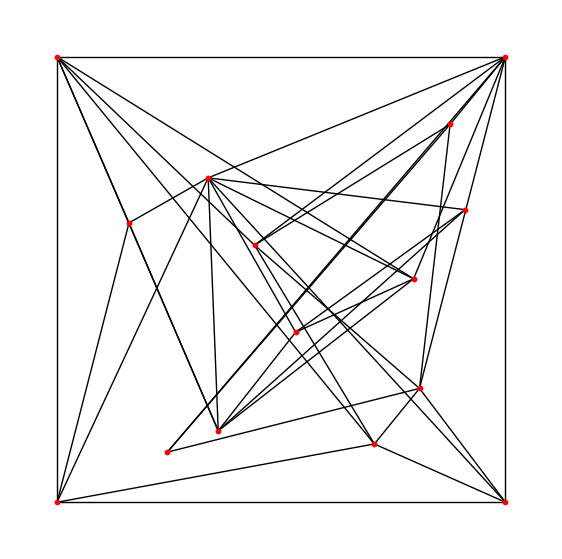

In [63]:
# this code for a square outer face
hw_sq = 0.6
pos[face_a] = [center_x - hw_sq, center_y + hw_sq]
pos[face_b] = [center_x + hw_sq, center_y + hw_sq]
pos[face_c] = [center_x + hw_sq, center_y - hw_sq]
pos[face_d] = [center_x - hw_sq, center_y - hw_sq]

fixed_vertices = [face_a, face_b, face_c, face_d]

for i in range(N):
    if not i in fixed_vertices:
        x = random()
        y = random()
        pos[i] = [x, y]

pos_copy = pos.copy()
G_copy = G.copy()
TuttePlot(G, pos, "red")

## Not quite


The above plot shows the graph with the four-edge Everything Else face and the remaining vertices placed
at random. The following plots show that the code is not working as advertised. 

Graph with 15 nodes and 39 edges


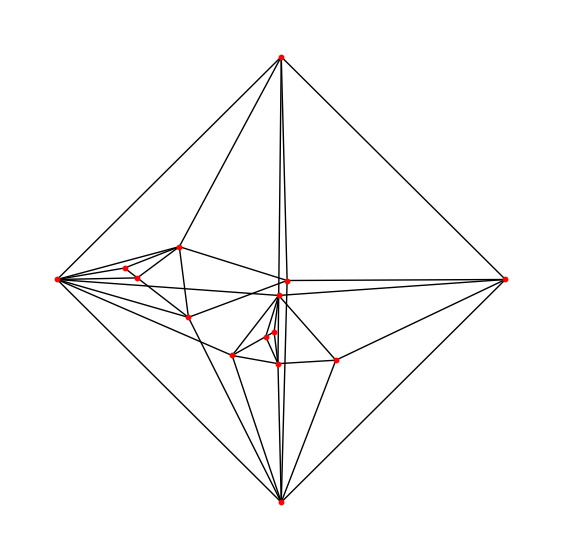

In [66]:
pos_tutte = tutte_embedding(G, 
              [(face_a, face_b), (face_b, face_c), 
               (face_c, face_d), (face_a, face_d)])
TuttePlot(G, pos_tutte, "red")

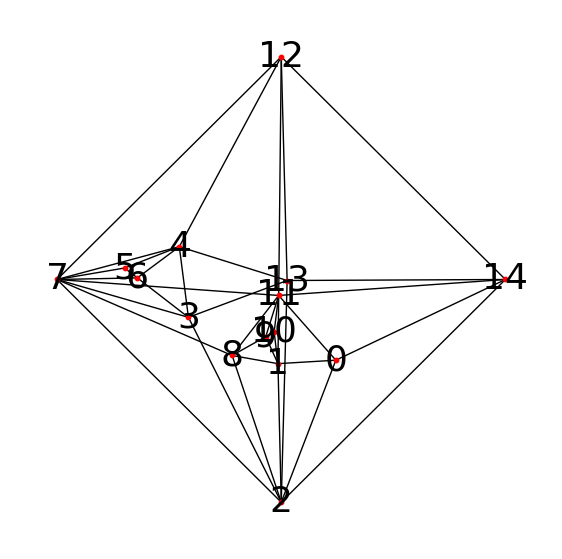

In [67]:
TuttePlot(G, pos_tutte, "red", True)

### Method 1: Springs

In [68]:
# Generate an adjacency list of lists
adjacent = []
for i in range(N):
    this_a = []
    for j in range(N):
        if G_copy.has_edge(i, j): this_a.append(j)
    adjacent.append(this_a)

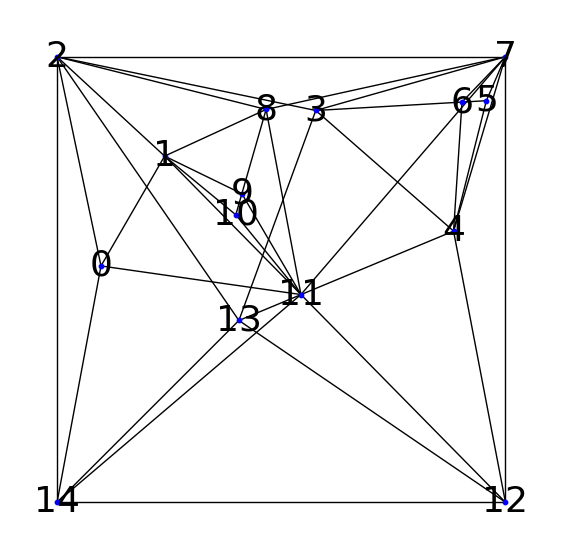

In [69]:
nTimes = 20000
epsilon = .01
pin_factor = 3         # stronger strings at the pinned vertices

for time in range(nTimes):
    for i in range(N):
        if not i in fixed_vertices:
            x_sum = 0.
            y_sum = 0.
            for neighbor in adjacent[i]:
                if neighbor in fixed_vertices:
                    x_sum += pin_factor*(pos_copy[neighbor][0] - pos_copy[i][0])
                    y_sum += pin_factor*(pos_copy[neighbor][1] - pos_copy[i][1])
                else:
                    x_sum += pos_copy[neighbor][0] - pos_copy[i][0]
                    y_sum += pos_copy[neighbor][1] - pos_copy[i][1]
            # if i == 7: print(x_sum, y_sum)
            pos_copy[i][0] += x_sum * epsilon
            pos_copy[i][1] += y_sum * epsilon

plt.figure(figsize=(7, 7))
nx.draw_networkx_edges(G_copy, pos_copy)
nx.draw_networkx_nodes(G_copy, pos_copy, node_size=10, node_color = 'blue')
labels = nx.draw_networkx_labels(G_copy, pos_copy, font_size = 26)

# nx.draw_networkx_edges(G_copy, pos_copy, edge_color = 'red')
# nx.draw_networkx_nodes(G_copy, pos_copy, node_size=10, node_color = 'red')
plt.axis('off')
plt.show()

In [70]:
print(nx.is_planar(G))

True


# Move this to GraphMechanics.ipynb
## The problem is it relies on G planar which is established up in the Tutte Emb
### The intent is to show more NetworkX features
### So disentangle from Tutte and relocate


In [95]:
nx.is_planar(G)

True

In [96]:
pos[7][0], pos[7][1]

(0.9134856010136331, 0.3701914105265768)

In [97]:
fixed_vertices

[3, 2, 0, 4]

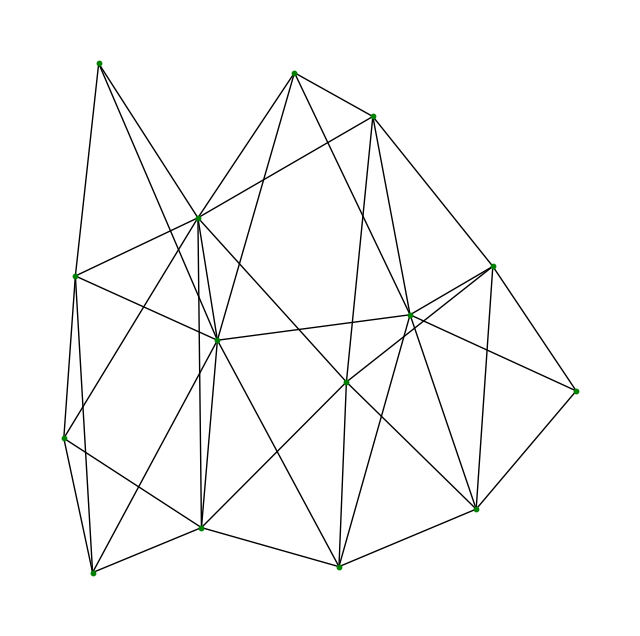

In [98]:
pos=nx.spring_layout(G)
plt.figure(figsize=(8, 8))
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_nodes(G, pos, node_size=10, node_color = 'green')
plt.axis('off')
plt.show()

In [ ]:
G = nx.random_geometric_graph(15, 0.40)
F = hamiltonian(G)
print(F)

```
F = hamiltonian(G)    # run with 20 vertices and p = 0.4; single component graph
F                     # will give an H path (not cycle)

[0, 3, 4, 16, 19, 17, 14, 13, 11, 12, 18, 9, 8, 5, 7, 1, 10, 6, 15, 2]
```

Let's decipher the brute force code above. $n$ is the number of nodes in $G$. Here is a paraphrase of a repl: 

```
F = [(G,[list(G.nodes())[0]])]
print(type(F[0]), len(F[0]), type(F[0][0]), type(F[0][1]), len(F[0][1]), type(F[0][1][0]), F[0][1][0])

'tuple', 2, graph G, 'list', 1, 'int', 0
```

From this we see that F is a list of one element; which is a 2-ple: The passed graph G and (second) a list of length 1, with list[0] = 0. 
This zero is the index of the first element of G's node list, i.e. the start of a path. The second element of the tuple (i.e. the list) 
will prove to be a path of vertices. 


The `while` loop runs until `F` is empty.


`graph, path = F.pop()` breaks out the `F` tuple into `graph` and `path`; leaving `F` an empty list after the pop(). Remember `path` will grow.


`confs` is an empty list that grows as we go. It accumulates (Graph, path-list) tuples.


`neighbors` is a list of nodes that are neighbors to the last node on the working `path`... excluding that node itself. This implies that if 
G has self-loops then `.neighbors(node)` would include 'myself'.  

Incidentally `G.neighbors(node)` returns an enumerable; I found it expedient to use it like `range()`: 

```
for i in G.neighbors(4): print(i)

9 18 11 13 6 8 17 19 1 3 12 5 14 7 16
```

As the while progresses brute force additions are made to generate new paths and graphs that have the newest path vertext removed. 
I'll leave it at that for now but it is an interesting bit of code. 

In [99]:
G.nodes()

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14))

In [100]:
G.edges()

EdgeView([(0, 1), (0, 14), (0, 5), (0, 9), (0, 6), (0, 8), (0, 4), (0, 2), (1, 2), (1, 3), (1, 4), (2, 3), (2, 14), (2, 13), (2, 6), (3, 4), (3, 6), (4, 5), (4, 6), (5, 6), (6, 7), (6, 13), (6, 8), (7, 8), (7, 13), (7, 9), (7, 12), (8, 9), (9, 10), (9, 14), (9, 12), (9, 11), (10, 11), (10, 14), (10, 12), (10, 13), (11, 12), (12, 13), (13, 14)])

In [101]:
n4s = 0
for edge in G.edges: n4s += 1 if 4 == edge[0] or 4 == edge[1] else 0
n4s

5

In [102]:
type(G.edges())

networkx.classes.reportviews.EdgeView

In [71]:
import numpy.linalg

# These imports give us control sliders that we use for selecting depth slices from the dataset
from ipywidgets import *
from traitlets import dlink
 
e = []
v = []

# This creates a 2D color-coded view of oxygen at the surface, attaching a slider to a depth parameter
def DrawSomeGraph(type_choice, n, control, layout):
    
    global e, v
    
    plt.figure(num=None, figsize=(6,6), dpi=80)
    plt.axis('off')
    fig = plt.figure(1)
    
    title_string = 'i was never given a title for this... odd'

    probability = float(control)/100.0

    if type_choice == 0: # G(n,m) chooses one possible graph with n vertices and m edges at random
        m = control # number of edges
        G = nx.gnm_random_graph(n, m)
        title_string = 'Randomly chosen from among all graphs with m vertices and n edges'
    elif type_choice == 1: 
        G = nx.random_graphs.erdos_renyi_graph(n, probability)
        title_string = 'Erdos-Renyi random graph with probability ' + str(probability)
    elif type_choice == 2:
        # Use this graph to win a trophy at an information theory conference
        G=nx.karate_club_graph()
        title_string = 'The Karate club graph; go claim your trophy!'
    elif type_choice == 3: 
        G = nx.heawood_graph()
        title_string = 'Heawood graph, a cubic graph on 14 vertices with girth 6'
    elif type_choice == 4:
        k = min(n, 5)
        G = nx.newman_watts_strogatz_graph(n, k, probability)
        title_string = 'Small world graph'
    elif type_choice == 5: 
        k = min(n, 10)
        G = nx.powerlaw_cluster_graph(n, k, probability)
        title_string = 'Power law cluster graph'
    elif type_choice == 6: 
        k = int(control * n / 100)
        if k < 1: k = 1
        G = nx.barabasi_albert_graph(n, k)
        title_string = 'Preferential attachment graph'
    elif type_choice == 7: 
        G = nx.complete_graph(n)
        title_string = 'complete graph'
    elif type_choice == 8: 
        G = nx.complete_multipartite_graph(n, control)
        title_string = 'complete bipartite n, m'
    elif type_choice == 9: 
        # since the size parameter is a dimension (exponent) we auto-curtail this
        if n > 7: n = 7
        G = nx.hypercube_graph(n)
        title_string = 'Hypercube graph where n is now the dimension'
    elif type_choice == 10: 
        G = nx.random_lobster(n, probability, probability)
        title_string = 'random lobster with both probabilities ' + str(probability)
    else:
        distance_threshold = float(control)/100.
        G = nx.random_geometric_graph(n, distance_threshold)
        title_string = 'random geometric using a threshold of ' + str(distance_threshold)

    
    # Use the layout parameter to choose an arrangement scheme
    if layout == 0:
        pos=nx.circular_layout(G)
        title_string += '    (circular)'
    elif layout == 1:
        pos=nx.random_layout(G) 
        title_string += '    (random)'
    elif layout == 2:
        if type_choice == 9:
            # Multiple shells hang on a hypercube 
            pos=nx.shell_layout(G)
        else: 
            shells = []
            nShells = 1
            if n > 5: nShells += 1
            if n > 11: nShells += 1
            if n > 36: nShells += 1
            if n > 72: nShells += 1
            deltaShell = int(n / nShells)
            # n = 43 gives nShells = 4, deltaShell = 10; 0-10, 10-20, 20-30, 30-40
            for i in range(nShells):
                shells.append(range(int(i*deltaShell), int((i+1)*deltaShell)))
            if n > nShells * deltaShell: 
                shells.append(range(int(nShells*deltaShell), n))
            pos=nx.shell_layout(G, shells) 
        title_string += '    (shell)'
    elif layout == 3:
        pos=nx.spring_layout(G) 
        title_string += '    (spring)'
    elif layout == 4:
        pos=nx.spectral_layout(G)
        title_string += '    (spectral)'
    else: # there is a 'graphviz' layout but not using this 'pos =' mechanism
        pos=nx.circular_layout(G)
        title_string += '    (circular)'
    
    # This does not work properly
    # nx.draw(G)
    cut = 1.1
    xmax = cut * max(xx for xx, yy in pos.values())
    ymax = cut * max(yy for xx, yy in pos.values())
    xmin = cut * min(xx for xx, yy in pos.values())
    ymin = cut * min(yy for xx, yy in pos.values())
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.title(title_string)

    nx.draw_networkx(G,pos,with_labels=False,node_size=50,node_color='blue')
    plt.show()
    
    # print(title_string)
    
    L = nx.normalized_laplacian_matrix(G)
    e, v = numpy.linalg.eig(L.A)
    e.sort()
    for i in range(len(e)):
        if e[i] < 1.0e-14: e[i] = 0
    eivstring = "Eigenvalues:"
    nTerms = min(n, 9)
    for i in range(nTerms):
        eivstring += '%.3f' % e[i] + ', '
    if n > 10: eivstring += ', ..., '
    eivstring += '%.3f' % e[n-1]
    print(eivstring)
    # plt.hist(e, bins=100)  # histogram with 100 bins
    # plt.xlim(0, 2)  # eigenvalues between 0 and 2 
          
# This is the interactive slider
interact(DrawSomeGraph, 
            type_choice={'Gnm random': 0, \
                         'Erdos-Renyi random': 1, \
                         'Karate Club': 2, \
                         'Heawood Graph': 3, \
                         'Small world': 4, \
                         'Power law cluster': 5, \
                         'Preferential attachment': 6, \
                         'Complete': 7, \
                         'Complete Bipartite': 8, \
                         'Hypercube': 9, \
                         'Random Lobster': 10 \
                        }, 
            # type_choice=widgets.IntSlider(min=0,max=20,step=1,value=2, continuous_update=False),
            n=widgets.IntSlider(min=2,max=100,step=1,value=10, continuous_update=False),
            control=widgets.IntSlider(min=0,max=100,step=1,value=50,continuous_update=False),
            layout = {'circular': 0, \
                      'random': 1, \
                      'shell': 2, \
                      'spring': 3, \
                      'spectral': 4
                        }
        )

interactive(children=(Dropdown(description='type_choice', options={'Gnm random': 0, 'Erdos-Renyi random': 1, '…

<function __main__.DrawSomeGraph(type_choice, n, control, layout)>